In [3]:
import tensorflow as tf
from tensorflow.keras import layers,Sequential,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_dir=r"C:\Users\mdabd\Downloads\Staging Content\Stagging Project\chest_xray\train"
test_dir=r"C:\Users\mdabd\Downloads\Staging Content\Stagging Project\chest_xray\test"
val_dir=r"C:\Users\mdabd\Downloads\Staging Content\Stagging Project\chest_xray\val"

In [5]:
# All images will be rescaled by 1./255 and transformed
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [10]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


In [11]:
# Load images in batches from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [14]:
# Load ResNet50 pre-trained model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [15]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Add new layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

In [17]:
# Model finalization
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Compile model
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5


C:\Users\mdabd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - accuracy: 0.7112 - loss: 0.6555 - val_accuracy: 0.5625 - val_loss: 0.7445
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.7754 - loss: 0.4553 - val_accuracy: 0.5625 - val_loss: 1.0368
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.8021 - loss: 0.4218 - val_accuracy: 0.6250 - val_loss: 0.5722
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.8105 - loss: 0.4002 - val_accuracy: 0.5625 - val_loss: 0.7078
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.7971 - loss: 0.4277 - val_accuracy: 0.6250 - val_loss: 0.6924


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

In [21]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)

# Predict classes for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

C:\Users\mdabd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.7731 - loss: 0.4809
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step


In [22]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred > 0.5)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 67 167]
 [ 93 297]]


In [23]:
# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred > 0.5))

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.29      0.34       234
           1       0.64      0.76      0.70       390

    accuracy                           0.58       624
   macro avg       0.53      0.52      0.52       624
weighted avg       0.56      0.58      0.56       624



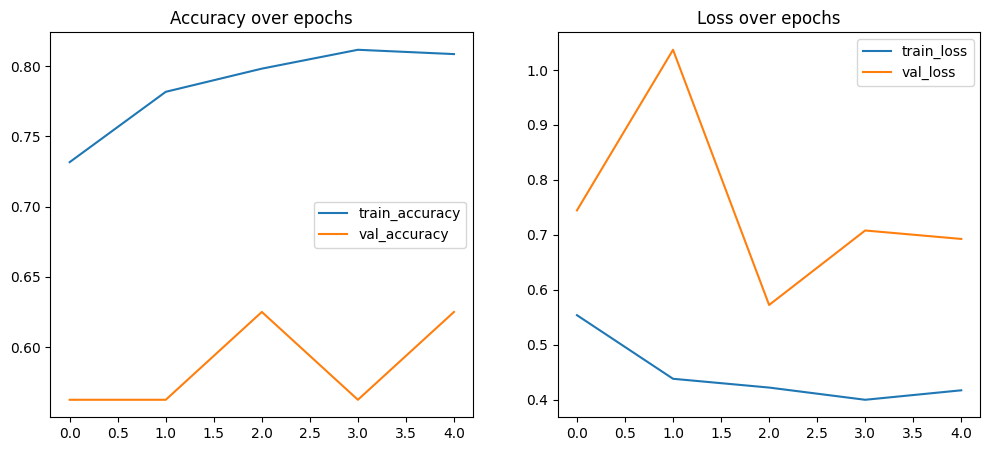

In [24]:
# Plotting accuracy and loss
def plot_performance(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    plt.show()

plot_performance(history)

In [25]:
model.save('X-ray model.h5')

In [30]:
%run app.py

 * Serving Flask app 'app'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1